# Create components in the core group

The "core group" is just a convention used in this package. It contains:
- The plasma
- The vacuum between the plasma and the vessel (arbitrarily called here SOL-vacuum)
- The vacuum vessel
- The blanket
- The neutron shield

In the future some more versatility will be added:
- First wall component
- Blanket outer boundary will be able to have a different shape than the inner (not only a vessel polygon offset then)
- possibility of adding dedicated shield components that do not embed the whole blanket (it can be done via the [Polygon](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.model.Polygon.html?highlight=polygon) class already)
- Add a channel layer in the vacuum vessel (or multiple structural layers)

In [1]:
import openmc
import tokamak_radiation_environment as tre
import matplotlib.pyplot as plt

/home/segantin/miniconda3/envs/openmc_env2/lib/python3.11/site-packages/openmc/material.py:1449: UserWarning: Warning: sum of fractions do not add to 1, void fraction set to 0.09999999999999987
  warnings.warn(msg)


### Disclaimer 

Leghts are in [cm]

All the components proposed here are built with the [openmc.model.Polygon](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.model.Polygon.html?highlight=polygon) class of openmc. It is then possible to directly use that class for more versatility already.

The [openmc.model.Polygon](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.model.Polygon.html?highlight=polygon) class requires a list of points coordinates that will be connected by lines. Coordinates are given by a couple of floating numbers and can refer to any of the 'xy', 'xz', 'yz' or 'rz' planes. The polygon gets then 'extruded' on the direction perpendicular to the reference plane for an undefined extension. In the case of 'rz' plane the extrusion is revolved around the z plane which is helpful in order to design toroidal geometries.

In [2]:
# import materials
tungsten = tre.materials.tungsten
beryllium = tre.materials.beryllium
eurofer = tre.materials.eurofer97
flibe = tre.materials.flibe
wc = tre.materials.wc

## Component objects

All the components have a "angle" argument that allows the user build just a slice of the tokamak using cutter planes perpendicular to the 'xy' plane. The angle must be a tuple of two angles defined in degrees.

The plasma component needs the nodes coordinates (in 'rz' plane by default) for the plasma outer boundary. The vessel component needs the inner nodes coordinates (surface clostest to the plasma).

We here provide an easy example with the ARC-class nodes.

In [3]:
plasma_nodes = (
    [443, 0],
    [435, 35],
    [417, 73],
    [392, 113],
    [356, 156],
    [312, 193],
    [295, 199],
    [281, 196],
    [272, 185],
    [260, 156],
    [240, 92],
    [223, 36],
    [217, 0],
    [223, -36],
    [240, -92],
    [260, -156],
    [272, -185],
    [281, -196],
    [295, -199],
    [312, -193],
    [356, -156],
    [392, -113],
    [417, -73],
    [435, -35]
)

fw_nodes = (
    [454, 0],
    [453, 22],
    [435, 89],
    [334, 197],
    [322, 207],
    [287, 227],
    [248, 225],
    [247, 204],
    [243, 183],
    [223, 119],
    [210, 36],
    [209, 0],
    [210, -36],
    [223, -119],
    [243, -183],
    [247, -204],
    [248, -225],
    [287, -227],
    [322, -207],
    [334, -197],
    [435, -89],
    [453, -22]  # Closing vertex to complete the hexagon
)

#### Plasma component

In [4]:
# Plasma
plasma = tre.components.Plasma(outer_nodes=plasma_nodes, material=None, surf_offset=0., angle=None)

In OpenMC with constructive solid geometry every body has its surfaces, its region and its cell. With 'tre' it is possible to extract all of them. Cells being the most important for the simulation.

In [5]:
print(f'Surfaces: {plasma.surfaces}')
print(f'Region: {plasma.region}')
print(f'Cell: {plasma.cell}')

Surfaces: <Polygon at 0x7f6189478e10>
Region: ((((145 -146) | 146) ((147 -148) | 148) (-149 150) (-151 152) ((153 154) | -154) ((155 156) | -156) (-157 -158) (-159 -160) ((161 -162) | 162) ((163 -164) | 164) ((165 -166) | 166) ((167 -168) | 168) (-169 170) (-171 172) (-173 174) (-175 176) ((177 178) | -178) ((179 180) | -180) ((181 182) | -182) ((183 184) | -184) (-185 -186) (-187 -188) (-189 -190) (-191 -192)))
Cell: Cell
	ID             =	1
	Name           =	
	Fill           =	None
	Region         =	((((241 -242) | 242) ((243 -244) | 244) (-245 246) (-247 248) ((249 250) | -250) ((251 252) | -252) (-253 -254) (-255 -256) ((257 -258) | 258) ((259 -260) | 260) ((261 -262) | 262) ((263 -264) | 264) (-265 266) (-267 268) (-269 270) (-271 272) ((273 274) | -274) ((275 276) | -276) ((277 278) | -278) ((279 280) | -280) (-281 -282) (-283 -284) (-285 -286) (-287 -288)))
	Rotation       =	None
	Translation    =	None
	Volume         =	None



#### Vacuum vessel components

Vacuum vessel components have been split in several different layers according to the classic ARC-class reactor radial build:
- First wall
- Vessel inner structure
- Cooling channel
- Neutron multiplier
- Vessel outer structure

In [6]:
# Vessel

first_wall = tre.components.FirstWall(inner_nodes=fw_nodes, thickness=.1, material=tungsten, angle=None)
vessel_inner_structure = tre.components.VesselInnerStructure(
    first_wall=first_wall, thickness=1., material=eurofer, angle=None)
vessel_cooling_channel = tre.components.VesselCoolingChannel(
    vessel_inner_structure=vessel_inner_structure, thickness=2., material=flibe, angle=None)
vessel_neutron_multiplier = tre.components.VesselNeutronMultiplier(
    vessel_cooling_channel=vessel_cooling_channel, thickness=1., material=beryllium, angle=None)
vessel_outer_structure = tre.components.VesselOuterStructure(
    vessel_neutron_multiplier=vessel_neutron_multiplier, thickness=3., material=eurofer, angle=None)

#### SOL-vacuum component
The SOL-vacuum component is defined as the volume between the plasma outer surface and the vessel inner surface. It then needa both the plasma component and the vessel component. From them it estracts their nodes and fills the space in between.

In [7]:
# SOL vacuum

sol = tre.components.SOLVacuum(plasma=plasma, first_wall=first_wall, material=None, angle=None)

#### Blanket component
The blanket uses the same vacuum vessel inner nodes from which it adds the vessel thickness to find the blanket inner surface and the blanket thickness in order to find the outer blanket surface. It then requires the vessel component as argument in order to extract the nodes and the vessel thickness.

info: blanket accepts also a "nodes" argument which can be used in place of the 'thickness' in order to provide a different shape for the blanket outer surface.

In [8]:
# Blanket

blanket = tre.components.Blanket(vacuum_vessel=vessel_outer_structure, thickness=50, material=flibe, nodes=None, angle=None)

#### Shield component

The shield requires the blanket component in order to extract the blanket outer surface nodes and offset them outwards according to the thickness provided.

In [9]:
# Shield

shield = tre.components.Shield(blanket=blanket, thickness=30, material=wc, nodes=None, angle=None)

## Core group function
The core group function helps to generate all the component objects in the core in just one call. It can used as alternative to the workflow that builds component by component presented just above.
It is necessary to provide:
- plasma_outer_nodes: coordinates of the nodes for building the plasma polygon
- plasma_material: material for filling the plasma cell (defaults to None, namely void)
- vessel_inner_nodes: coordinates of the nodes for building the vacuum vessel inner polygon 
- (the "sol" component gets created as the space between the plasma_outer_nodes and the vessel_inner_nodes)
- vessel_thickness: offsets the vessel_inner_nodes outwards by this value (cm)
- vessel_material: material for the vacuum vessel component
- blanket_thickness: offsets the vessel_inner_nodes outwards by this value plus the vessel thickness (cm)
- blanket_material: material for the blanket component
- shield_thickness: offsets the vessel_inner_nodes outwards by this value plus plus the blanket thickness the vessel thickness (cm)
- shield_material: material for the shield component
- angle: instead of a 360 deg tokamak get a slice equal to this angle (deg) in the domain [-angle/2, +angle/2)

In [10]:
# core
plasma, sol, first_wall, vessel_inner_structure, vessel_cooling_channel, vessel_neutron_multiplier, vessel_outer_structure, blanket, shield = tre.components.core_group(
    plasma_outer_nodes=plasma_nodes, plasma_material=None,
    firstwall_inner_nodes=fw_nodes, firstwall_thickness=.1, firstwall_material=tungsten,
    vv_stri_thickness=1., vv_stri_material=eurofer,
    vv_channel_thickness=2., vv_channel_material=flibe,
    vv_multiplier_thickness=1., vv_multiplier_material=beryllium,
    vv_stro_thickness=3., vv_stro_material=eurofer,
    blanket_thickness=55, blanket_material=flibe,
    shield_thickness=30, shield_material=wc,
    angle=None)

### Collect the cells in openmc geometry

In [11]:
root = [plasma.cell, sol.cell, first_wall.cell, vessel_inner_structure.cell, 
        vessel_cooling_channel.cell, vessel_neutron_multiplier.cell, vessel_outer_structure.cell, 
        blanket.cell, shield.cell]

geometry = openmc.Geometry(root=root)

## Visualize geometry

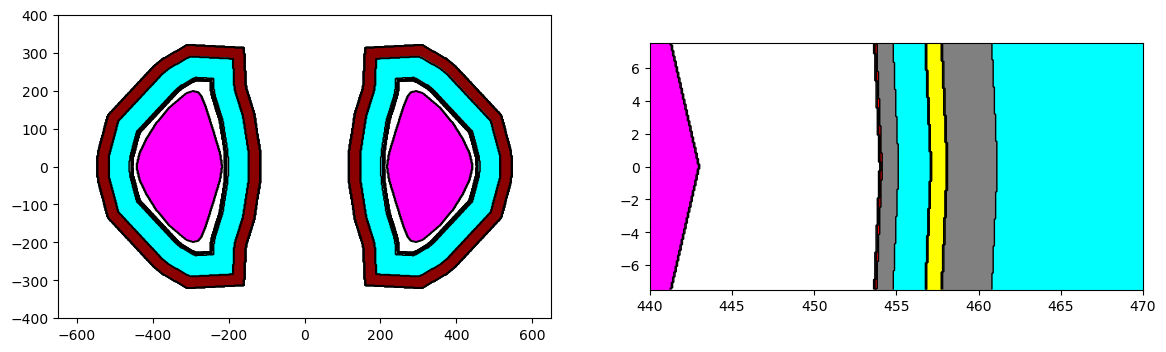

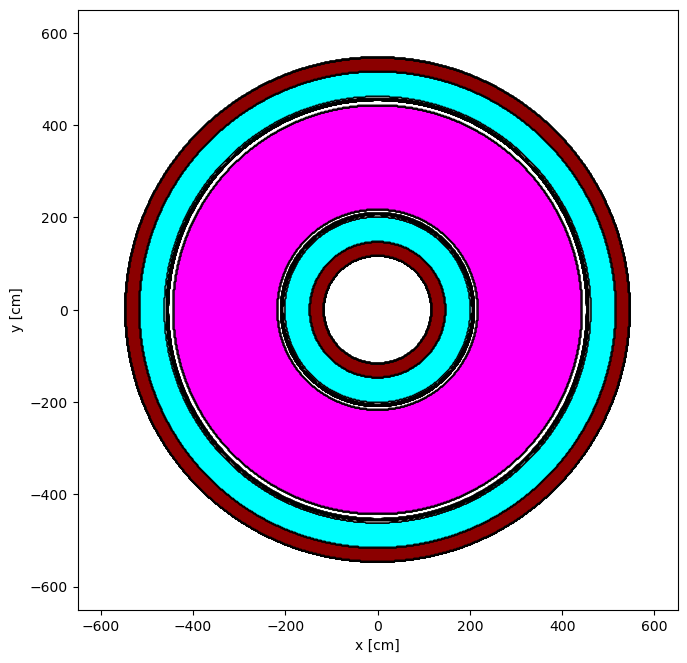

In [12]:
universe = openmc.Universe(cells=root)

colors={root[0]:'magenta', root[1]:'white', root[2]:'red', root[3]:'grey', root[4]:'aqua', 
        root[5]:'yellow', root[6]:'grey', root[7]:'aqua', root[8]:'darkred'}

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,7))
universe.plot(origin=(0, 0, 0), basis='xz', width=[1300, 800], pixels=[600, 600], axes=ax1, 
              color_by='cell', colors=colors, outline=True)
universe.plot(origin=(455, 0, 0), basis='xz', width=[30, 15], pixels=[400, 400], axes=ax2, 
              color_by='cell', colors=colors, outline=True)
plt.show()

universe.plot(origin=(0, 0, 0), basis='xy', width=[1300, 1300], pixels=[600, 600], 
              color_by='cell', colors=colors, outline=True)
plt.show()